# Classifier #
This implements a simple classifier to test out a GPU via Docker.

## Setup ##

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


Verify that the GPU is accessible.

In [2]:
if torch.cuda.is_available():
    print('The list of detected devices:')
    for i in range(torch.cuda.device_count()):
        print(F'{torch.cuda.get_device_name(i)}')
    device = torch.device('cuda')
else:
    print('No GPU detected!')
    device = torch.device('cpu')


The list of detected devices:
NVIDIA GeForce RTX 3080


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


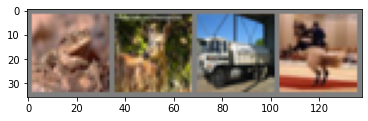

frog  deer  truck horse


In [4]:
def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Neural Network ##
Define the classifier.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)


Define the loss function.

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Training ##

In [7]:
start_time = time.time()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(F'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
end_time = time.time()
duration = end_time - start_time
print(F'Finished training in {duration:.4f} seconds.')


[1,  2000] loss: 2.198
[1,  4000] loss: 1.838
[1,  6000] loss: 1.660
[1,  8000] loss: 1.585
[1, 10000] loss: 1.516
[1, 12000] loss: 1.442
[2,  2000] loss: 1.393
[2,  4000] loss: 1.350
[2,  6000] loss: 1.354
[2,  8000] loss: 1.327
[2, 10000] loss: 1.305
[2, 12000] loss: 1.256
Finished training in 57.1471 seconds.


## Testing ##

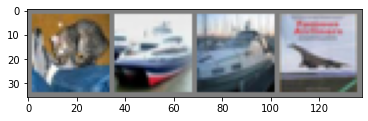

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   car   plane plane


In [8]:
net = net.cpu()
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(
    F'Accuracy of the network on the 10000 test images: {100 * correct // total}%')


Accuracy of the network on the 10000 test images: 55%
